In [1]:
import cv2
from utils import get_train_raw_dataset, polyp_size
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Create polyp crop dataset

In [2]:
BORDER = 30
SAVE_ROOT = './polyp_crop'

In [4]:
ds = get_train_raw_dataset()
ds_name = 'SunDataset'

for ds_name in ['SunDataset', 'TrainDataset']:
    print("Process", ds_name)

    # Prepare save directory
    save_dir = os.path.join(SAVE_ROOT, ds_name)
    img_save_dir = os.path.join(save_dir, "images")
    gt_save_dir = os.path.join(save_dir, "masks")
    shutil.rmtree(save_dir, ignore_errors=True)
    os.makedirs(img_save_dir)
    os.makedirs(gt_save_dir)

    n_imgs = len(ds.filenames[ds_name])
    for i in range(n_imgs):
        filename = ds.filenames[ds_name][i]
        img = ds.get_img(ds_name, i)
        gt = ds.get_gt(ds_name, i)
        x,y,w,h = cv2.boundingRect(gt)
        x2, y2 = x + w, y + h

        H, W = img.shape[0], img.shape[1]
        x = max(0, x - BORDER)
        y = max(0, y - BORDER)
        x2 = min(W - 1, x2 + BORDER)
        y2 = min(H - 1, y2 + BORDER)

        img_crop = img[y:y2+1, x:x2+1, :]
        gt_crop = gt[y:y2+1, x:x2+1]
        cv2.imwrite(os.path.join(img_save_dir, filename), img_crop)
        cv2.imwrite(os.path.join(gt_save_dir, filename), gt_crop)

        if i % 100 == 99:
            print(f"Img {i}/{n_imgs}")

Process SunDataset
Img 99/983
Img 199/983
Img 299/983
Img 399/983
Img 499/983
Img 599/983
Img 699/983
Img 799/983
Img 899/983
Process TrainDataset
Img 99/1450
Img 199/1450
Img 299/1450
Img 399/1450
Img 499/1450
Img 599/1450
Img 699/1450
Img 799/1450
Img 899/1450
Img 999/1450
Img 1099/1450
Img 1199/1450
Img 1299/1450
Img 1399/1450


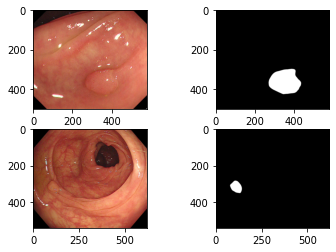

In [22]:

img_idx1 = 147
img1 = ds.get_img(ds_name='SunDataset', img_idx=img_idx1)
gt1 = ds.get_gt(ds_name='SunDataset', img_idx=img_idx1)
img_idx2 = 189
img2 = ds.get_img(ds_name='SunDataset', img_idx=img_idx2)
gt2 = ds.get_gt(ds_name='SunDataset', img_idx=img_idx2)

plt.subplot(221), plt.imshow(img1[:,:,::-1])
plt.subplot(222), plt.imshow(gt1, cmap='gray')
plt.subplot(223), plt.imshow(img2[:,:,::-1])
plt.subplot(224), plt.imshow(gt2, cmap='gray')
plt.show()

In [11]:
def cutmix2(img1, gt1, img2, gt2):
    """
    Resize source to match destination. Then copy polyp from source and paste to destination.
    
    Params:
        img1, gt1: destination
        img2, gt2: source
    """
    height, width = img1.shape[0], img1.shape[1]
    img2 = cv2.resize(img2, dsize=(width, height))
    gt2 = cv2.resize(gt2, dsize=(width, height))

    kernel = np.ones((5,5), np.uint8)
    dilation = cv2.dilate(gt2, kernel, iterations = 10)
    mask = cv2.blur(dilation / 255, (50, 50))

    mask = np.stack((mask, mask, mask), axis=2)
    img_ret = img2/255 * mask + img1/255 * (1-mask)

    return img_ret, None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


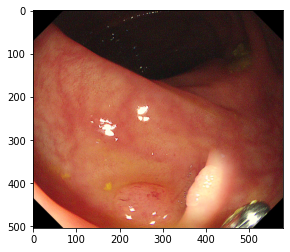

In [12]:
img_ret, gt_ret = cutmix2(img2, gt2, img1, gt1)
plt.imshow(img_ret[:,:,::-1])

In [13]:
import albumentations as A
def random_rotate(img, gt):
    A.rotate()
    transform = A.Rotate(border_mode=None,)
    res = transform(image=img, mask=gt)
    return res['image'], res['mask']

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x25bd8f2d160>)

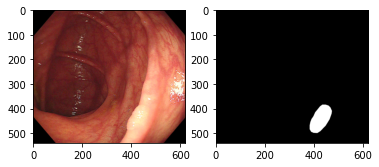

In [14]:
rot_img, rot_gt = random_rotate(img=img1, gt=gt1)
plt.subplot(121), plt.imshow(rot_img[:,:,::-1])
plt.subplot(122), plt.imshow(rot_gt, cmap='gray')